In [2]:
import os, time
import json
from multiprocessing import Pool

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import *
from glob import glob
from sklearn.manifold import TSNE
from numpy import reshape
from sklearn.decomposition import PCA
import random
from tqdm.auto import tqdm
from adjustText import adjust_text

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
total = 25576
prev_data = []
for i in range(25576):
    print(i)
    with open(f'', 'r') as f:
        d = json.load(f)
    prev_data += d
print(len(prev_data))
# 2336263

In [2]:
num_processes = os.cpu_count()
num_processes

64

In [12]:
def to_include(post):
    return post['subreddit'] != "FiftyFifty"

In [3]:
def multi_process(num_processes, f, data):
    with Pool(num_processes) as p:
        results = p.map(f, data)
    return results

In [4]:
def traverse(children_tree, f, target, outputs):
    for node in children_tree:
        f(node, target, outputs)
        traverse(node["children"], f, target, outputs) 

In [14]:
# remove subreddit FiftyFifty
results = multi_process(num_processes, to_include, prev_data)

In [16]:
data = [d for (keep, d) in zip(results,prev_data) if keep]
print(len(data))
# 2331142

2331142


In [17]:
# with open('', 'w') as outfile:
#     outfile.write(json.dumps(data, indent=4))

# Experiment 1

In [43]:
with open('', 'r') as f:
    data=json.load(f)

In [6]:
# def ex1_f(children, target, outputs):
#     if children['author'] == target['author']:
#         return
#     for span in children['spans']:
#         outputs.append({
#         'subreddit': children['subreddit'],
#         'appraisal': span[2],
#         'role': 'observer',
#         'comment_id': children['id'],
#         'seq_id': children['seq_id']
#     })

In [132]:
# only consider the target the top-level commments
def ex1_main(post):
    outputs = []
    for span in post['spans']:
        outputs.append({
            'subreddit': post['subreddit'],
            'appraisal': span[2],
            'role': 'target',
            'comment_id': post['id'],
            'seq_id': post['seq_id']
        })
        # top level comments
        for comment in post["comments"]:
            for span in comment['spans']:
                outputs.append({
                    'subreddit': comment['subreddit'],
                    'appraisal': span[2],
                    'role': 'observer',
                    'comment_id': comment['id'],
                    'seq_id': comment['seq_id']
                    })
            
    return outputs
        

In [133]:
results = multi_process(num_processes, ex1_main, data)

In [134]:
results = [item for sublist in results for item in sublist]

In [135]:
# with open("", 'w') as outfile:
#     outfile.write(json.dumps(results, indent=4))

In [136]:
df = pd.DataFrame.from_dict(results)

In [ ]:
df.head()

In [138]:
Counter(df.subreddit)

Counter({'depression': 18613151,
         'BPD': 8304920,
         'dementia': 1512427,
         'Vent': 6485681,
         'abusiverelationships': 3753404,
         'offmychest': 36538700,
         'lonely': 4447852,
         'BreakUps': 15023410,
         'socialskills': 7263371,
         'CautiousBB': 467054,
         'Advice': 56225810,
         'TalkTherapy': 3379323,
         'MomForAMinute': 7095842,
         'adultsurvivors': 3188269,
         'getdisciplined': 3130964,
         'MadeMeCry': 89846,
         'NarcissisticAbuse': 9303757,
         'bipolar': 6620526,
         'SuicideWatch': 12399027,
         'Anxiety': 9390974,
         'widowers': 4717864,
         'selfharm': 3158359,
         'GriefSupport': 5507230,
         'BPDlovedones': 9134468,
         'SingleParents': 1807712,
         'Anger': 715079,
         'mentalhealth': 10852690,
         'datingoverforty': 5770844,
         'heartbreak': 1712578,
         'emotionalabuse': 1461812,
         'ExNoContact': 4898

In [139]:
Counter(df[df.role == 'target'].appraisal)

Counter({'Advice': 1843177,
         'Certainty': 3289277,
         'Pleasantness': 2914815,
         'Self-Other Agency': 3942027,
         'Situational Control': 1988532,
         'Anticipated Effort': 3524524,
         'Objective Experience': 4213142})

In [140]:
Counter(df[df.role == 'observer'].appraisal)

Counter({'Objective Experience': 41305972,
         'Pleasantness': 28261311,
         'Self-Other Agency': 52317797,
         'Anticipated Effort': 34026814,
         'Situational Control': 12725092,
         'Advice': 83314520,
         'Trope': 24292830,
         'Certainty': 50645998})

In [16]:
target_counts_df = df[df.role == 'target'].groupby(['subreddit', 'appraisal']).count().reset_index()
target_counts_df.rename(columns={'role': 'Count'}, inplace=True)
a = target_counts_df.groupby('subreddit')['Count'].apply(lambda x: sum(x)).reset_index()
ac = {r.subreddit:r.Count for r in a.itertuples()}
target_counts_df['Probability'] = target_counts_df.apply(lambda r: int(r.Count) / float(ac[r.subreddit]), axis=1)
target_counts_df.head()

,subreddit,appraisal,Count,comment_id,seq_id,Probability
0,Advice,Advice,402148,402148,402148,0.108108
1,Advice,Anticipated Effort,565631,565631,565631,0.152056
2,Advice,Certainty,584421,584421,584421,0.157107
3,Advice,Objective Experience,849087,849087,849087,0.228256
4,Advice,Pleasantness,317221,317221,317221,0.085277


In [142]:
observer_counts_df = df[df.role == 'observer'].groupby(['subreddit', 'appraisal']).count().reset_index()
observer_counts_df.rename(columns={'role': 'Count'}, inplace=True)
a = observer_counts_df.groupby('subreddit')['Count'].apply(lambda x: sum(x)).reset_index()
ac = {r.subreddit:r.Count for r in a.itertuples()}
observer_counts_df['Probability'] = observer_counts_df.apply(lambda r: int(r.Count) / float(ac[r.subreddit]), axis=1)
observer_counts_df.head()

,subreddit,appraisal,Count,comment_id,seq_id,Probability
0,Advice,Advice,21049101,21049101,21049101,0.400890
1,Advice,Anticipated Effort,3447373,3447373,3447373,0.065657
2,Advice,Certainty,8165854,8165854,8165854,0.155523
3,Advice,Objective Experience,5328469,5328469,5328469,0.101483
4,Advice,Pleasantness,2343781,2343781,2343781,0.044638


In [18]:
tdf = target_counts_df[['subreddit', 'appraisal', 'Probability']]
pivot_tgt = tdf.pivot(columns='appraisal', index='subreddit', values='Probability').reset_index().fillna(0)

In [ ]:
# pivot_tgt.to_csv("", index=False)

In [25]:
pivot_tgt = pd.read_csv("")

In [26]:
X_tgt = pivot_tgt[pivot_tgt.columns[1:]].to_numpy()

In [27]:
pivot_tgt

,subreddit,Advice,Anticipated Effort,Certainty,Objective Experience,Pleasantness,Self-Other Agency,Situational Control
0,Advice,0.108108,0.152056,0.157107,0.228256,0.085277,0.199195,0.070000
1,Alzheimers,0.133036,0.120711,0.120884,0.287831,0.094497,0.180834,0.062207
2,Anger,0.091986,0.191501,0.124336,0.140002,0.146029,0.215152,0.090995
3,Anxiety,0.112278,0.161739,0.137390,0.184378,0.190157,0.090825,0.123234
4,AskPsychiatry,0.144779,0.141067,0.171828,0.286137,0.079105,0.098104,0.078980
...,...,...,...,...,...,...,...,...
86,socialskills,0.140476,0.150952,0.152480,0.186996,0.082815,0.198735,0.087546
87,therapy,0.103788,0.172681,0.160842,0.187901,0.110470,0.177669,0.086648
88,traumatoolbox,0.118642,0.145682,0.139813,0.213946,0.114799,0.170207,0.096912
89,ttcafterloss,0.131605,0.155448,0.154902,0.300625,0.150946,0.055400,0.051073


In [28]:
pca = PCA(n_components=4)
pca.fit(X_tgt)
Z = pca.transform(X_tgt)
pca.explained_variance_ratio_

array([0.55594122, 0.26399006, 0.12761082, 0.0294003 ])

In [29]:
pca.components_

array([[-0.13491042, -0.27662337, -0.15297695,  0.87175557,  0.11312355,
        -0.31208423, -0.10828416],
       [ 0.63840532,  0.242149  , -0.03855873, -0.05813351, -0.14290603,
        -0.70977339,  0.06881736],
       [ 0.42174011,  0.01386162, -0.13556954,  0.2438582 , -0.62231107,
         0.45977617, -0.3813555 ],
       [ 0.12830091, -0.49610197,  0.81617305, -0.05328452, -0.05760916,
        -0.10478837, -0.23268994]])

In [30]:
pca_df = pd.DataFrame()
#pca_df["y"] = y
pca_df["comp1"] = Z[:,0]
pca_df["comp2"] = Z[:,1]
pca_df["comp3"] = Z[:,2]
pca_df["comp4"] = Z[:,3]
pca_df["label"] = pivot_tgt.subreddit
pca_df.head()

,comp1,comp2,comp3,comp4,label
0,-0.018609,-0.014709,0.042578,0.015441,Advice
1,0.051791,0.002727,0.060888,0.004657,Alzheimers
2,-0.099649,-0.027618,-0.019229,-0.038298,Anger
3,-0.017164,0.059203,-0.098951,-0.009655,Anxiety
4,0.057568,0.075360,0.023948,0.043388,AskPsychiatry


In [31]:
# labels to include:
target_graph_labels_to_include = [
#      'Advice',
     'Alzheimers',
#      'Anger',
     'Anxiety',
#      'AskPsychiatry',
     'BPD',
#      'BPD4BPD',
#      'BPDPartners',
#      'BPDlite',
#      'BPDlovedones',
#      'BPDrecovery',
     'BipolarSOs',
#      'BodyAcceptance',
#      'BorderlinePDisorder',
#      'BreakUp',
#      'BreakUps',
     'CBT',
     'COVIDgrief',
     'CPTSD',
     'CPTSDNextSteps',
     'CancerCaregivers',
#      'CaregiverSupport',
     'CautiousBB',
#      'ChildrenofDeadParents',
#      'Codependency',
     'DecidingToBeBetter',
     'EmotionalAbuseSupport',
#      'ExNoContact',
#      'FriendsOver40',
     'GriefSupport',
     'Grieving',
     'IWantToLearn',
#      'InternalFamilySystems',
#      'LifeAfterNarcissism',
#      'MMFB',
     'MadeMeCry',
#      'MentalHealthUK',
     'Miscarriage',
#      'MomForAMinute',
     'NarcAbuseAndDivorce',
#      'NarcissisticAbuse',
     'NarcissisticSpouses',
     'OCD',
     'OldManDog',
     'Petloss',
#      'PrayerRequests',
     'PregnancyAfterLoss',
#      'SingleParents',
#      'SuicideBereavement',
#      'SuicideWatch',
#      'TalkTherapy',
#      'Vent',
     'abusiverelationships',
#      'adultsurvivors',
#      'askatherapist',
     'askfuneraldirectors',
     'bipolar',
     'cancer',
#      'cptsdcreatives',
#      'datingoverfifty',
#      'datingoverforty',
     'dbtselfhelp',
     'death',
     'dementia',
#      'depression',
     'domesticviolence',
     'emotionalabuse',
#      'emotionalneglect',
     'gaslighting',
     'getdisciplined',
#      'grief',
     'happycryingdads',
#      'heartbreak',
     'lastimages',
#      'lonely',
#      'marriageadvice',
     'mentalhealth',
     'narcissism',
#      'offmychest',
     'productivity',
     'psychotherapy',
#      'sad',
#      'selfharm',
     'selfimprovement',
     'seniorkitties',
#      'socialanxiety',
#      'socialskills',
#      'therapy',
     'traumatoolbox',
     'ttcafterloss',
#      'widowers'
]

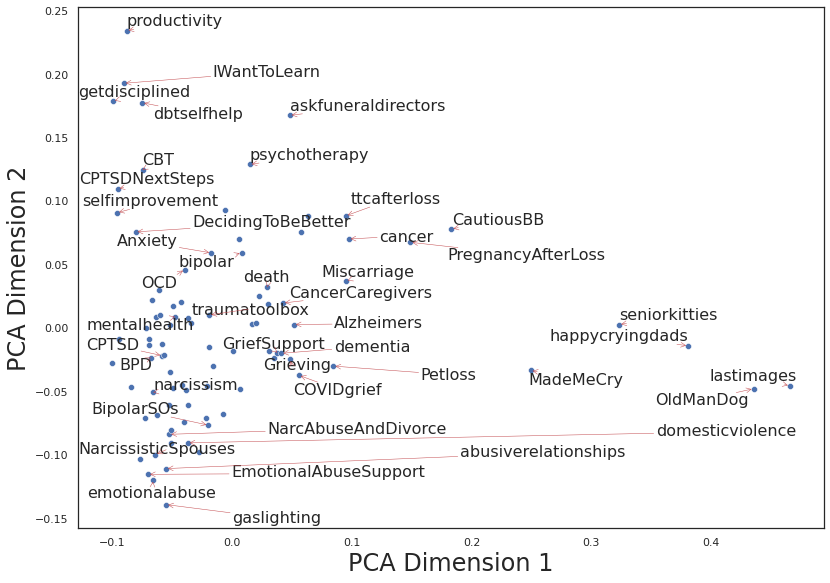

In [32]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('white')

#def label_point(x, y, val, ax, offset=.003):
#    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#    for i, point in a.iterrows():
#        ax.text(point['x'] + offset, point['y'], str(point['val'].replace('_', ' ')))

def label_point(x, y, val, ax, offset=.003):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    texts = []
    for i, point in a.iterrows():
        #ax.text(point['x'] + offset, point['y'], str(point['val'].replace('_', ' ')))
        texts.append(ax.text(point['x'], point['y'], str(point['val']), fontsize = 16))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

    # draw all points        
ax = sns.scatterplot(data=pca_df, x="comp1", y="comp2") #, hue='label', style='label')

# label part of the point
label_pca_df = pca_df[pca_df['label'].isin(target_graph_labels_to_include)]
label_point(label_pca_df.comp1, label_pca_df.comp2, label_pca_df.label, plt.gca())  
#plt.legend(bbox_to_anchor=(.62, 1.05), loc='upper center', 
#           borderaxespad=0,  prop={'size': 16})

plt.xlabel('PCA Dimension 1', fontsize=24)
plt.ylabel('PCA Dimension 2', fontsize=24)
plt.tight_layout()
plt.savefig('')

In [150]:
odf = observer_counts_df[['subreddit', 'appraisal', 'Probability']]
pivot_obs = odf.pivot(columns='appraisal', index='subreddit', values='Probability').reset_index().fillna(0)

In [ ]:
# pivot_obs.to_csv("", index=False)

In [33]:
pivot_obs=pd.read_csv("")
X_obs = pivot_obs[pivot_obs.columns[1:]].to_numpy()

In [34]:
pca = PCA(n_components=4)
pca.fit(X_obs)
Z = pca.transform(X_obs)
pca.explained_variance_ratio_

array([0.51447908, 0.24516403, 0.13311411, 0.06225326])

In [35]:
pca.components_

array([[-0.67804566, -0.10880765, -0.07437772,  0.21264278,  0.3320731 ,
        -0.26879137,  0.04380312,  0.5415034 ],
       [ 0.51099553,  0.04534336, -0.18486784,  0.2839056 , -0.07380974,
        -0.76497935,  0.00630218,  0.17711026],
       [ 0.30155995, -0.35882935,  0.04158284, -0.54782352, -0.09832183,
         0.12817201, -0.12685246,  0.66051235],
       [ 0.05596663, -0.53488242,  0.01500154,  0.66491825, -0.34097845,
         0.29828248, -0.23830449,  0.07999646]])

In [36]:
pca_df = pd.DataFrame()
#pca_df["y"] = y
pca_df["comp1"] = Z[:,0]
pca_df["comp2"] = Z[:,1]
pca_df["comp3"] = Z[:,2]
pca_df["comp4"] = Z[:,3]
pca_df["label"] = pivot_obs.subreddit
pca_df.head()

,comp1,comp2,comp3,comp4,label
0,-0.173546,0.041970,0.064587,0.029480,Advice
1,-0.001740,0.041929,-0.036871,0.046540,Alzheimers
2,-0.099973,0.009958,0.028216,-0.030927,Anger
3,0.013281,0.053164,-0.039161,-0.038521,Anxiety
4,-0.091004,0.119360,-0.038822,0.091429,AskPsychiatry


In [39]:
# labels to include:
observer_graph_labels_to_include = [
     'Advice',
     'Alzheimers',
     'Anger',
     'Anxiety',
     'AskPsychiatry',
#      'BPD',
#      'BPD4BPD',
     'BPDPartners',
     'BPDlite',
#      'BPDlovedones',
     'BPDrecovery',
     'BipolarSOs',
#      'BodyAcceptance',
#      'BorderlinePDisorder',
     'BreakUp',
#      'BreakUps',
     'CBT',
     'COVIDgrief',
     'CPTSD',
#      'CPTSDNextSteps',
#      'CancerCaregivers',
#      'CaregiverSupport',
     'CautiousBB',
#      'ChildrenofDeadParents',
     'Codependency',
     'DecidingToBeBetter',
     'EmotionalAbuseSupport',
#      'ExNoContact',
#      'FriendsOver40',
     'GriefSupport',
     'Grieving',
     'IWantToLearn',
#      'InternalFamilySystems',
#      'LifeAfterNarcissism',
#      'MMFB',
     'MadeMeCry',
     'MentalHealthUK',
     'Miscarriage',
#      'MomForAMinute',
#      'NarcAbuseAndDivorce',
     'NarcissisticAbuse',
     'NarcissisticSpouses',
     'OCD',
     'OldManDog',
     'Petloss',
     'PrayerRequests',
     'PregnancyAfterLoss',
#      'SingleParents',
     'SuicideBereavement',
#      'SuicideWatch',
#      'TalkTherapy',
#      'Vent',
     'abusiverelationships',
#      'adultsurvivors',
     'askatherapist',
     'askfuneraldirectors',
     'bipolar',
     'cancer',
     'cptsdcreatives',
     'datingoverfifty',
#      'datingoverforty',
     'dbtselfhelp',
     'death',
     'dementia',
     'depression',
#      'domesticviolence',
#      'emotionalabuse',
     'emotionalneglect',
     'gaslighting',
     'getdisciplined',
     'grief',
#      'happycryingdads',
     'heartbreak',
     'lastimages',
     'lonely',
     'marriageadvice',
     'mentalhealth',
     'narcissism',
#      'offmychest',
     'productivity',
     'psychotherapy',
#      'sad',
     'selfharm',
     'selfimprovement',
     'seniorkitties',
#      'socialanxiety',
#      'socialskills',
     'therapy',
     'traumatoolbox',
     'ttcafterloss',
#      'widowers'
]

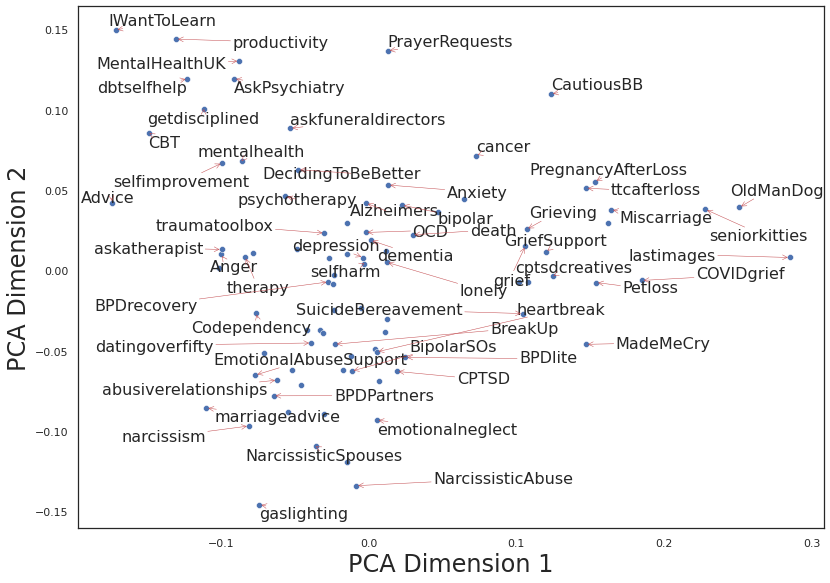

In [40]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('white')

def label_point(x, y, val, ax, offset=.003):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    texts = []
    for i, point in a.iterrows():
        #ax.text(point['x'] + offset, point['y'], str(point['val'].replace('_', ' ')))
        texts.append(ax.text(point['x'], point['y'], str(point['val']), fontsize=16))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
            
ax = sns.scatterplot(data=pca_df, x="comp1", y="comp2") #, hue='label', style='label')

label_pca_df = pca_df[pca_df['label'].isin(observer_graph_labels_to_include)]
label_point(label_pca_df.comp1, label_pca_df.comp2, label_pca_df.label, plt.gca())  

#plt.legend(bbox_to_anchor=(.62, 1.05), loc='upper center', 
#           borderaxespad=0,  prop={'size': 16})

plt.xlabel('PCA Dimension 1', fontsize=24)
plt.ylabel('PCA Dimension 2', fontsize=24)
plt.tight_layout()
plt.savefig('')

## Alignment Analysis

In [155]:
# def traverse_alignment(children_tree, outputs):
#     for node in children_tree:
#         for alignment in node["alignments"]:
#             outputs[(alignment[0][2],alignment[1][2])] += 1
#         traverse_alignment(node["children"], outputs) 

In [5]:
def ex1_alignment_main(post):
    outputs = defaultdict(int)
    for node in post["comments"]:
        for alignment in node["alignments"]:
            outputs[(alignment[0][2],alignment[1][2])] += 1
    return outputs

In [6]:
len(data)

2331142

In [7]:
results = multi_process(num_processes, ex1_alignment_main, data)

In [8]:
# merge results
align_counts = Counter()
for result in results:
    align_counts = align_counts + Counter(result)
align_counts

Counter({('Advice', 'Self-Other Agency'): 407042,
         ('Advice', 'Anticipated Effort'): 762468,
         ('Certainty', 'Pleasantness'): 333951,
         ('Pleasantness', 'Pleasantness'): 1209860,
         ('Pleasantness', 'Anticipated Effort'): 209934,
         ('Self-Other Agency', 'Pleasantness'): 324252,
         ('Self-Other Agency', 'Situational Control'): 159696,
         ('Certainty', 'Advice'): 2421139,
         ('Objective Experience', 'Objective Experience'): 1341705,
         ('Self-Other Agency', 'Advice'): 1225429,
         ('Pleasantness', 'Situational Control'): 199215,
         ('Pleasantness', 'Objective Experience'): 315638,
         ('Self-Other Agency', 'Objective Experience'): 585164,
         ('Anticipated Effort', 'Advice'): 2197719,
         ('Situational Control', 'Self-Other Agency'): 305639,
         ('Certainty', 'Self-Other Agency'): 925469,
         ('Certainty', 'Situational Control'): 195341,
         ('Self-Other Agency', 'Self-Other Agency'): 3421

In [9]:
align_merged_counts = Counter()
for (first_element, _), count in align_counts.items():
    align_merged_counts[first_element] += count
align_merged_counts

Counter({'Advice': 4823969,
         'Certainty': 5870385,
         'Pleasantness': 3450352,
         'Self-Other Agency': 6894449,
         'Objective Experience': 4998970,
         'Anticipated Effort': 4412453,
         'Situational Control': 2301462})

In [10]:
align_df = defaultdict(list)
for index, (element, count) in enumerate(align_counts.items()):
    ta = element[0]
    oa = element[1]
    prob = count / align_merged_counts[ta]
    align_df['Target'].append(ta)
    align_df['Observer'].append(oa)
    align_df['Count'].append(count)
    align_df['Probability'].append(prob)  
            
align_df = pd.DataFrame(align_df)
align_df.head()

,Target,Observer,Count,Probability
0,Advice,Self-Other Agency,407042,0.084379
1,Advice,Anticipated Effort,762468,0.158058
2,Certainty,Pleasantness,333951,0.056887
3,Pleasantness,Pleasantness,1209860,0.350648
4,Pleasantness,Anticipated Effort,209934,0.060844


In [ ]:
align_df.to_csv("", index=False)

In [11]:
len(align_df)

46

In [12]:
pdf = align_df.pivot(index='Target', columns='Observer', values='Probability')

In [42]:
sns.set(font_scale=1.5)
g = sns.heatmap(pdf)
plt.xlabel('Aligned Observer Appraisal', fontsize = 20) # x-axis label with fontsize 15
plt.ylabel('Target Appraisal', fontsize = 20) # y-axis label with fontsize 15
# plt.tight_layout()
# plt.savefig('', bbox_inches = "tight")
set_xticklabels( ('A', 'B','C') )
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)

NameError: name 'pdf' is not defined